In [1]:
import os
import sys, getopt
import numpy as np

import matplotlib.pyplot as plt

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.filterwarnings('ignore')

This Jupyter file contains the code for producing the finite population dynamics of paiwise social dilemma.  As a first step a number of global variables are defined. 

In [2]:
N=100 #Population size
T=3. #Temptation to defect
R=7. #Reward for mutual cooperation
P=1. #Punishment for mutual defection
S=0. #Suckers payoff for unilateral cooperation
q=2 #Number of strategies
drift=1.0/N

strats=['C','D']
payoff=np.array([R,S,T,P]).reshape(2,2)
beta=0.01


Using these global variables one can now calculate the fixation probabilities (assuming the small mutation limit).  A number of helper functions are defined 

In [3]:
def fitness(k,invader, resident):
    '''
    The fitness function determines the average payoff of k invaders and N-k residents
    in the popiulation of N players. 
    '''
    resultA=(((k-1)*payoff[invader][invader])+((N-k)*payoff[invader, resident]))/float(N-1)
    resultB=((k*payoff[resident][invader])+((N-k-1)*payoff[resident, resident]))/float(N-1)
    return [resultA, resultB]

def fermifunc(b,first, second):
    '''
    The fermi function determines the probability that the first type imitates the second
    '''
    return 1./(1. + np.exp(-b*(first-second)))

def probIncreaseDecrease(k, invader, resident):
    '''
    This function calculates for a give number of invaders the probability 
    that the number increases or decreases with one. 
    '''
    fitvalue=fitness(k, invader, resident)
    increase=((N-k)/float(N))*(k/float(N))*fermifunc(-beta, fitvalue[1],fitvalue[0])
    decrease=((N-k)/float(N))*(k/float(N))*fermifunc(beta, fitvalue[1],fitvalue[0])
    return [increase,decrease]

def fixation(invader, resident):
    '''
    function for calculating the fixation probability of the invader 
    in a population of residents
    '''
    result=0.
    for i in range(1,N):
        sub=1.
        for j in range(1,i+1):
            tmp=probIncreaseDecrease(j,invader, resident)
            sub*=(tmp[1]/float(tmp[0]))
        result += sub
    return 1./(1. + result)

def transition_and_fixprob_matrix():
    transitions=np.zeros((q,q))
    fixprobs=np.zeros((q,q))
    for first in range(q):
        transitions[first,first]=1.
        for second in range(q) :
            if second != first :
                fp=fixation(second, first) 
                fixprobs[first][second]=(fp/drift)
                transitions[first][second]=fp/float(q-1)
                transitions[first][first]=transitions[first][first]-(fp/float(q-1))
    return [transitions,fixprobs]



Now we can start calculating the fixation probabilities between all pairs of strategies, which provides the transition matrix of the Markov chain.  Taking the 

In [4]:

t,f=transition_and_fixprob_matrix()
#print f
#print t

#calculate stationary distributions using eigenvalues and eigenvectors
w,v=np.linalg.eig(t.transpose())
j_stationary=np.argmin(abs(w-1.0)) #look for the element closest to 1 in the list of eigenvalues
p_stationary=abs(v[:,j_stationary].real) # the, is essential to access the matrix by column
p_stationary /= p_stationary.sum() #normalize

print ("transition probabilities (first %s, second %s and read as column invading row) \n %s" %(strats[0], strats[1],f))
print ("stationary distribution (first %s, second %s) \n %s" %(strats[0], strats[1], p_stationary))


transition probabilities (first C, second D and read as column invading row) 
 [[0.         0.29563229]
 [1.24777398 0.        ]]
stationary distribution (first C, second D) 
 [0.80845465 0.19154535]


## Now let's see how the stationary distributions change as a function of beta.

[[5.00360000e-01 4.99640000e-01]
 [5.03599938e-01 4.96400062e-01]
 [5.35937921e-01 4.64062079e-01]
 [8.08454651e-01 1.91545349e-01]
 [9.99999443e-01 5.57390059e-07]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]]
[0.50036    0.50359994 0.53593792 0.80845465 0.99999944 1.
 1.        ]


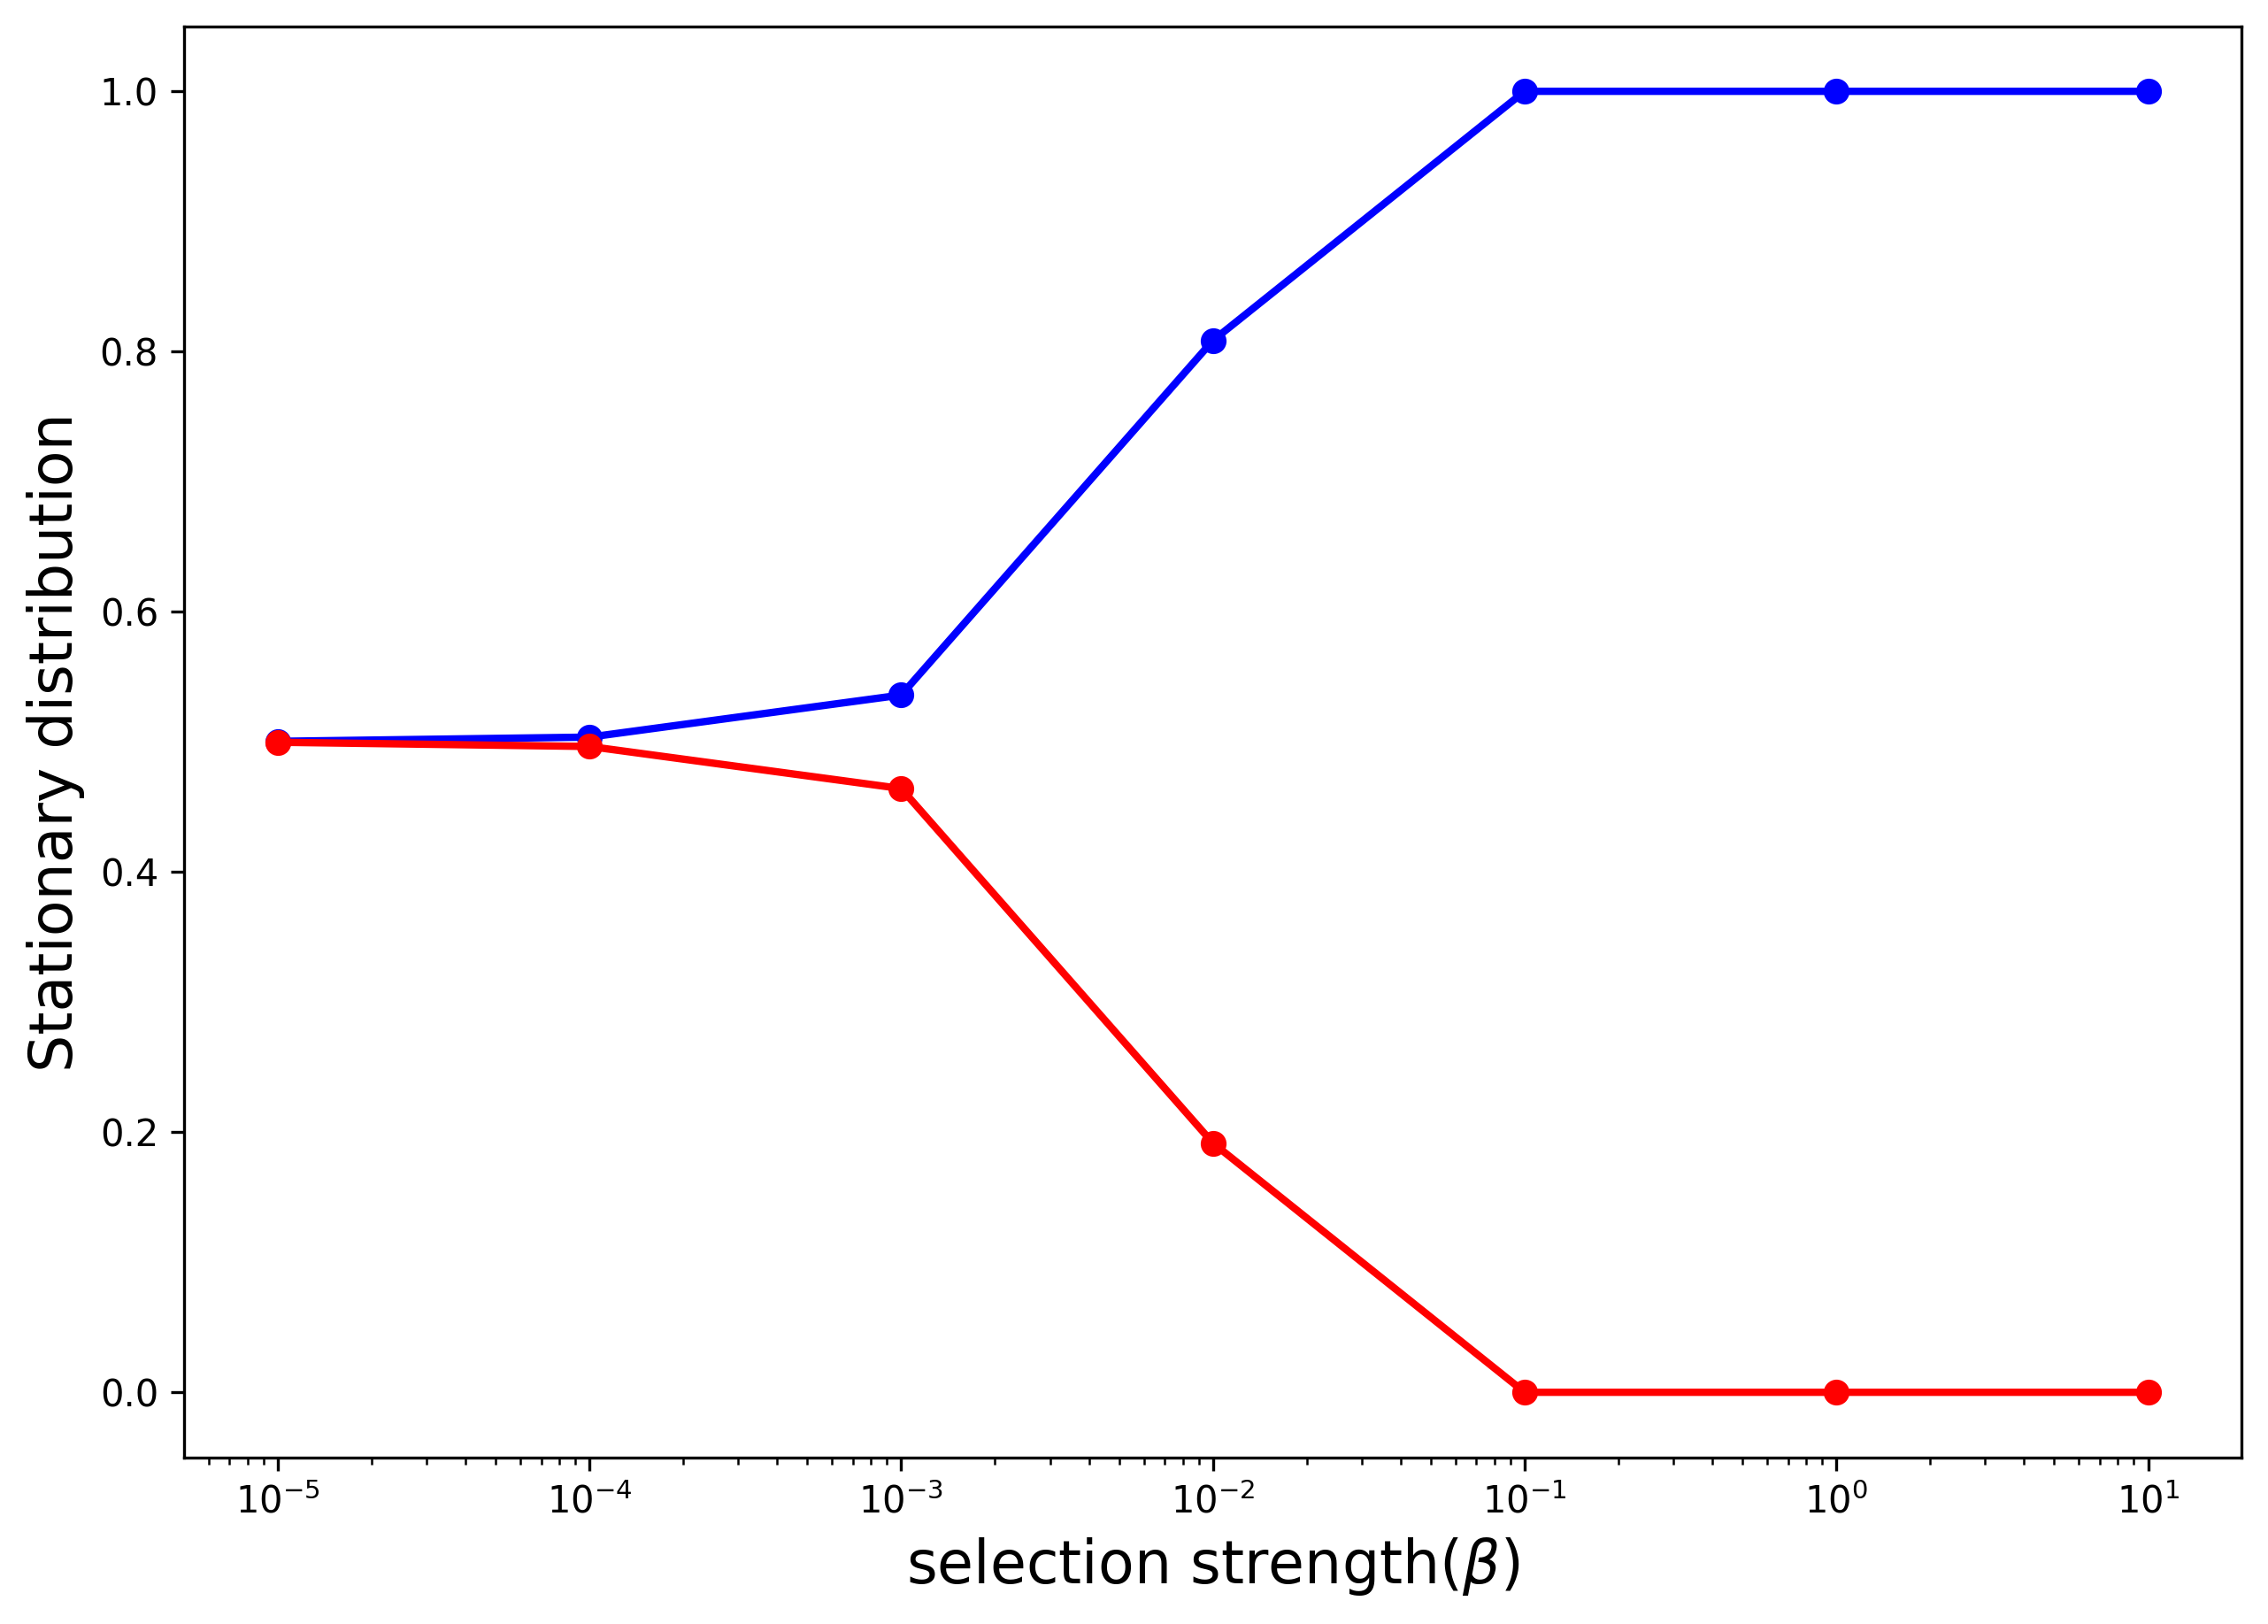

In [5]:
distribution=[]
betas=[0.00001,0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
for beta in betas:
    t,f=transition_and_fixprob_matrix()
    w,v=np.linalg.eig(t.transpose())
    j_stationary=np.argmin(abs(w-1.0)) 
    p_stationary=abs(v[:,j_stationary].real) 
    p_stationary /= p_stationary.sum()
    distribution.append(p_stationary)

darray=np.asarray(distribution)
print(darray)
print(darray[:,0])
fig = plt.figure(figsize=(10, 7), dpi=150)
lines=plt.plot(betas,darray[:,0],'bo-',betas,darray[:,1],'ro-')
plt.rc("font", size=14)
plt.xscale('log')
plt.setp(lines, linewidth=2.0)
plt.ylabel('Stationary distribution',size=16)
plt.xlabel('selection strength'+r'($\beta$)',size=16)
plt.ylim(-0.05,1.05)
plt.show()

So now lets look at the gradient of selection g(x): determine for different combinations of cooperators and defectors the difference between T+ and T-. 

[0.0, -0.00019431709781905435, -0.00025454477582900065, -0.00019962104901218025, -4.848484700077649e-05, 0.00017992418719806058, 0.00046666589849261864, 0.0007927998210073006, 0.0011393853793880693, 0.00148748209010717, 0.0018181497627618448, 0.002112448701361791, 0.002351439905599856, 0.0025161852721001104, 0.002587747795639042, 0.002547191770333218, 0.002375582990788924, 0.0020539889532079914, 0.0015634790564443765, 0.0008851248030066206, 0.0]


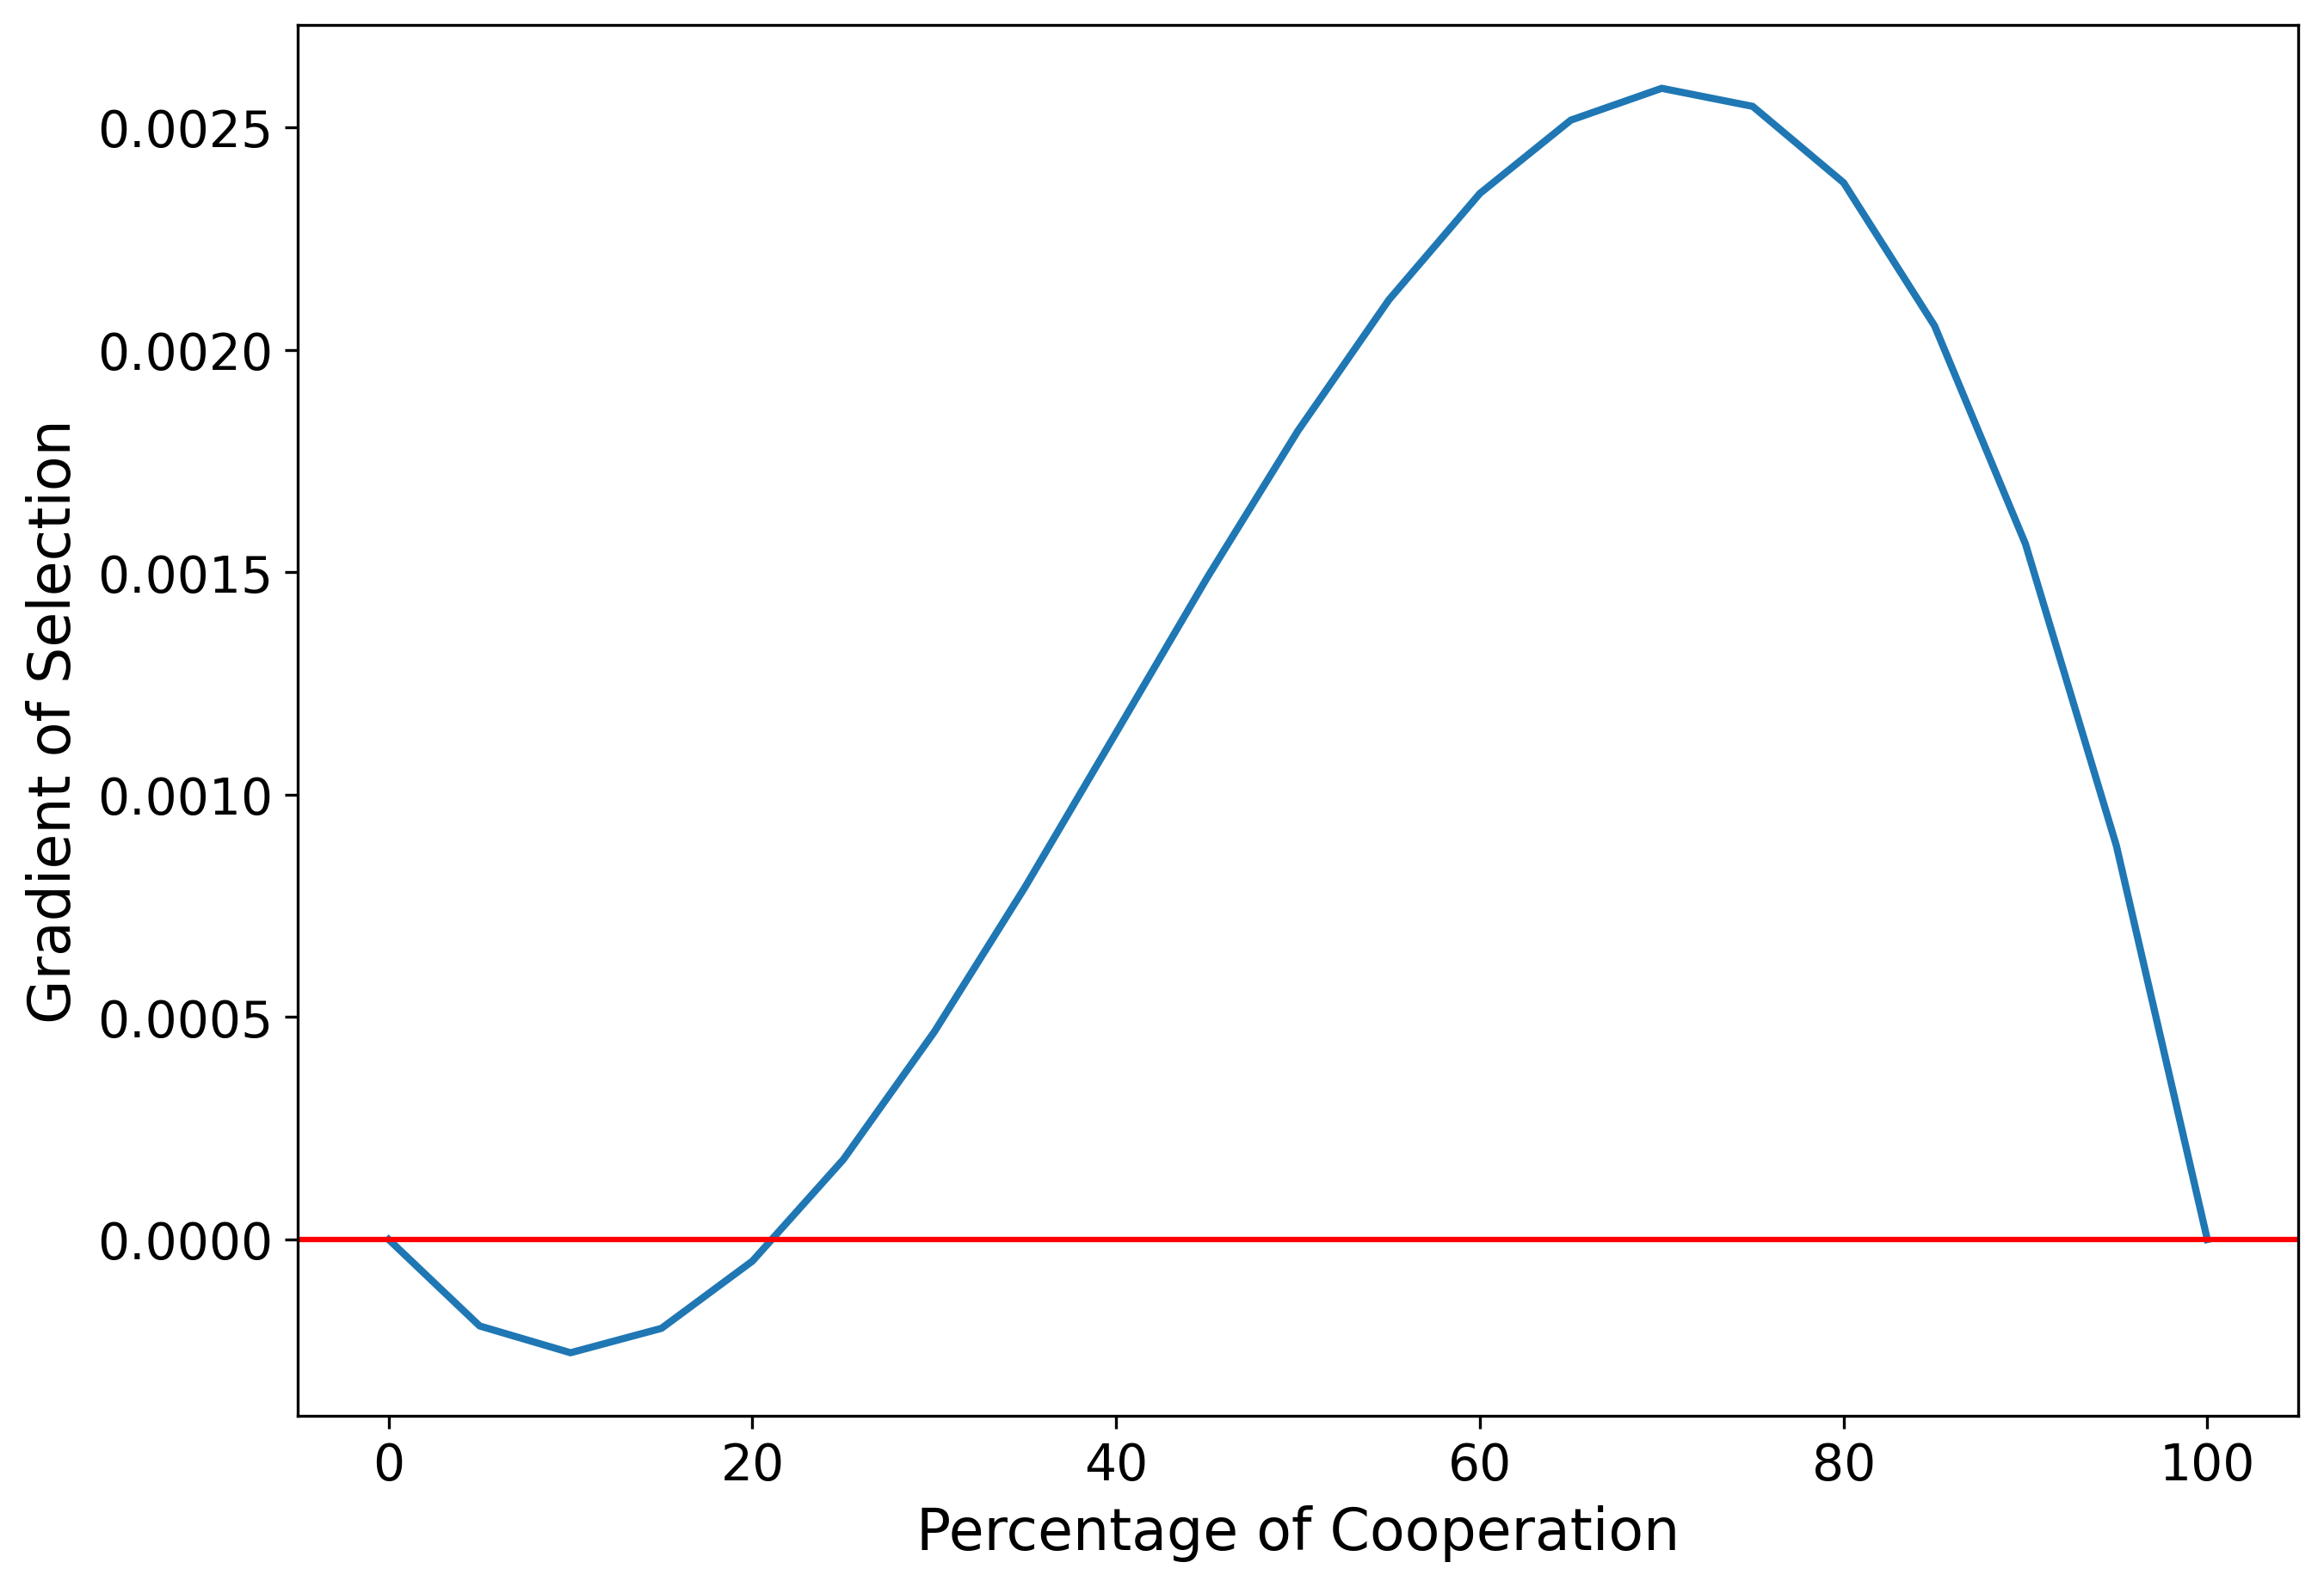

In [8]:
gradients=[]
coop_levels=np.arange(0,105,5)
beta=0.01
for coop in coop_levels:
    Tp,Tm=probIncreaseDecrease(coop,0,1)
    gradients.append(Tp-Tm)
print(gradients)

garray=np.asarray(gradients)
figg = plt.figure(figsize=(10, 7), dpi=150)
lines=plt.plot(coop_levels,garray,'-')
plt.rc("font", size=14)
plt.setp(lines, linewidth=2.0)
plt.ylabel('Gradient of Selection',size=16)
plt.xlabel('Percentage of Cooperation',size=16)
plt.axhline(0.0,color="red")
#plt.ylim(-0.5,0.5)
plt.show()